# Feature and Target Metadata Exploration

This notebook explores the metadata provided with the competition. There are two metadata files, 1. `features_metadata.csv` contains the metadata about the inputs (satellite images) and identifiers for training and testing images, along with other information and 2. `train_agbm_metadata.csv`, which contains the metadata for each target output image.

This notebook uses exploration to answer questions about the data, broadly, i.e., at a metadata level. For instance,

- What is the train/test split?
- How similar are the train/test images in terms of coverage, etc.?
- Each `chip` contains multiple images that make up the input and one output AGBM image. What is the coverage of images for each `chip`?
- What is the time range of data acquisition and prediction?

At a per-image level, I'm interested in knowing things like,

- What does each image look like? How are the different channels, bands represented in the image?
- How does each input pixel map to the AGBM ground truth value?
- How are the images split between the satellites (S1 and S2)?

## Steps

1. Features Metadata Exploration
   - Load data with Pandas
   - Groupby train/test
   - Note shapes of train/test sets

## Setup

In [3]:
from pathlib import Path

import pandas as pd

In [4]:
# DATA_DIR = Path(".").resolve().parent / "data/raw"  # old
DATA_DIR = Path("/datasets/biomassters")  # new with S3 as data source
feature_metadata_path = DATA_DIR / "features_metadata.csv"
train_agbm_path = DATA_DIR / "train_agbm_metadata.csv"
print(feature_metadata_path, train_agbm_path)

/datasets/biomassters/features_metadata.csv /datasets/biomassters/train_agbm_metadata.csv


## Input Features Metadata Exploration

In [5]:
# Load metadata into a Pandas DataFrame
feat_meta_df = pd.read_csv(feature_metadata_path)

In [6]:
def show_df_stats(df):
    rows, cols = df.shape
    print(f"Rows: {rows}\nColumns: {cols}")
    print(f"Column Names: {list(df.columns)}")
    print(df.info())

In [7]:
show_df_stats(feat_meta_df)

Rows: 252426
Columns: 11
Column Names: ['filename', 'chip_id', 'satellite', 'split', 'month', 'size', 'cksum', 's3path_us', 's3path_eu', 's3path_as', 'corresponding_agbm']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252426 entries, 0 to 252425
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   filename            252426 non-null  object
 1   chip_id             252426 non-null  object
 2   satellite           252426 non-null  object
 3   split               252426 non-null  object
 4   month               252426 non-null  object
 5   size                252426 non-null  int64 
 6   cksum               252426 non-null  int64 
 7   s3path_us           252426 non-null  object
 8   s3path_eu           252426 non-null  object
 9   s3path_as           252426 non-null  object
 10  corresponding_agbm  252426 non-null  object
dtypes: int64(2), object(9)
memory usage: 21.2+ MB
None


In [8]:
# Drop unnecessary columns
drop_cols = ["size", "cksum", "s3path_eu", "s3path_as"]
feat_meta_df.drop(columns=drop_cols, inplace=True)

In [9]:
# Save in Parquet/Arrow format -- skip
# feat_meta_df.to_parquet("../data/features_metadata_slim.parquet")

In [10]:
feat_meta_df.head()

,filename,chip_id,satellite,split,month,s3path_us,corresponding_agbm
0,0003d2eb_S1_00.tif,0003d2eb,S1,train,September,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif
1,0003d2eb_S1_01.tif,0003d2eb,S1,train,October,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif
2,0003d2eb_S1_02.tif,0003d2eb,S1,train,November,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif
3,0003d2eb_S1_03.tif,0003d2eb,S1,train,December,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif
4,0003d2eb_S1_04.tif,0003d2eb,S1,train,January,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif


### Train and Test Split Details

In [11]:
# First get rows marked as `train`, then get the shape of unique `chip_id`
unique_train_chips = feat_meta_df[feat_meta_df.split == "train"].chip_id.unique().shape[0]
# Next get rows marked as `test`, then get the shape of unique `chip_id`
unique_test_chips = feat_meta_df[feat_meta_df.split == "test"].chip_id.unique().shape[0]

In [12]:
print(f"There are {unique_train_chips} unique chip IDs in the training set")
print(f"There are {unique_test_chips} unique chip IDs in the testing set")

There are 8689 unique chip IDs in the training set
There are 2773 unique chip IDs in the testing set


In [13]:
nb_train_images = feat_meta_df[feat_meta_df.split == "train"].shape[0]
nb_test_images = feat_meta_df[feat_meta_df.split == "test"].shape[0]

In [14]:
print(f"Number of training images = {nb_train_images}")
print(f"Number of testing images = {nb_test_images}")

Number of training images = 189078
Number of testing images = 63348


Q: How many unique patches (chips) are in the training and testing set?

A: 8689 unique patches in the training set and 2773 unique patches in the testing set.

Q: How many training and testing images are there overall?

A: There are 189078 images in the training set and 63348 images in the test set. 

*Note that a single patch (chip) contains multiple images associated with it.*

The training set contains 189078 images while the test set contains 63348 images.

Next, let's find out how many images are available per satellite per month. If there are no missing images, then the total for each month for each satellite must be the same as the total number of unique chip IDs in the corresponding split (i.e., train or test).

In [15]:
train_sat_mo = feat_meta_df[feat_meta_df.split =="train"].groupby(["satellite", "month"])
test_sat_mo = feat_meta_df[feat_meta_df.split =="test"].groupby(["satellite", "month"])

In [16]:
print(train_sat_mo.count().chip_id)

satellite  month    
S1         April        8689
           August       8689
           December     8689
           February     8689
           January      8689
           July         8689
           June         8689
           March        8689
           May          8689
           November     8689
           October      8689
           September    8689
S2         April        8689
           August       8689
           December     1251
           February     6860
           January      5242
           July         8689
           June         8689
           March        8171
           May          8689
           November     6121
           October      6860
           September    6860
Name: chip_id, dtype: int64


In [17]:
print(test_sat_mo.count())

                     filename  chip_id  split  s3path_us  corresponding_agbm
satellite month                                                             
S1        April          2773     2773   2773       2773                2773
          August         2773     2773   2773       2773                2773
          December       2773     2773   2773       2773                2773
          February       2773     2773   2773       2773                2773
          January        2773     2773   2773       2773                2773
          July           2773     2773   2773       2773                2773
          June           2773     2773   2773       2773                2773
          March          2773     2773   2773       2773                2773
          May            2773     2773   2773       2773                2773
          November       2773     2773   2773       2773                2773
          October        2773     2773   2773       2773                2773

Let's visualize this distribution with `seaborn`.

In [19]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.pyplot.ion()

In [20]:
import seaborn as sns
sns.set()

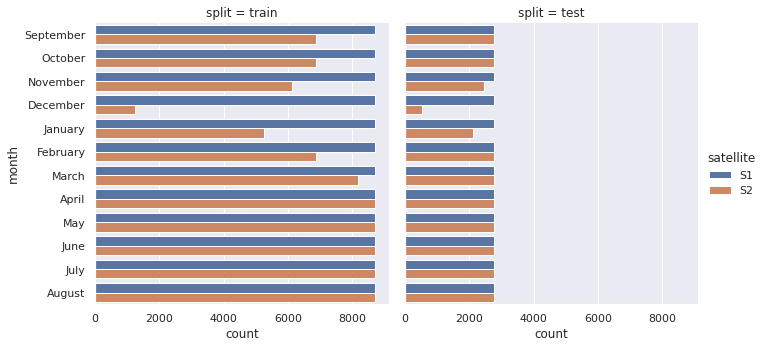

In [21]:
sns.catplot(data=feat_meta_df, y="month", kind="count", hue="satellite", col="split")

In [22]:
plt.savefig("../docs/count_satellite_month.png", dpi=300)

<Figure size 640x480 with 0 Axes>

Satellite images per each patch.

In [24]:
# Satellite images for each chip
train_chip_sat = feat_meta_df[feat_meta_df.split == "train"].groupby(["chip_id", "satellite"])

In [25]:
train_chip_sat.count().filename

chip_id   satellite
0003d2eb  S1           12
          S2            9
000aa810  S1           12
          S2            6
000d7e33  S1           12
                       ..
ffc7d4f2  S2           11
ffd8db7a  S1           12
          S2           11
fff05995  S1           12
          S2           11
Name: filename, Length: 17378, dtype: int64

## Output Metadata Exploration

In [26]:
agbm_meta_df = pd.read_csv(train_agbm_path)

In [27]:
show_df_stats(agbm_meta_df)

Rows: 8689
Columns: 7
Column Names: ['filename', 'chip_id', 'size', 'cksum', 's3path_us', 's3path_eu', 's3path_as']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8689 entries, 0 to 8688
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   8689 non-null   object
 1   chip_id    8689 non-null   object
 2   size       8689 non-null   int64 
 3   cksum      8689 non-null   int64 
 4   s3path_us  8689 non-null   object
 5   s3path_eu  8689 non-null   object
 6   s3path_as  8689 non-null   object
dtypes: int64(2), object(5)
memory usage: 475.3+ KB
None


In [28]:
agbm_meta_df.drop(columns=drop_cols, inplace=True)

In [29]:
agbm_meta_df.head()

,filename,chip_id,s3path_us
0,0003d2eb_agbm.tif,0003d2eb,s3://drivendata-competition-biomassters-public...
1,000aa810_agbm.tif,000aa810,s3://drivendata-competition-biomassters-public...
2,000d7e33_agbm.tif,000d7e33,s3://drivendata-competition-biomassters-public...
3,00184691_agbm.tif,00184691,s3://drivendata-competition-biomassters-public...
4,001b0634_agbm.tif,001b0634,s3://drivendata-competition-biomassters-public...


In [ ]:
# skip for now
# agbm_meta_df.to_parquet("../data/train_agbm_metadata_slim.parquet")